# Data preparation 

In [1]:
import sys, os 
import time
# dirname  = os.path.dirname(__file__)
# filename = os.path.join(dirname,"..")
quanTesterModulePath = "/Volumes/DATA_SCIENCES/DEV/Q26/Q26_QuanTester"
sys.path.append(quanTesterModulePath)

import numpy as np 
import pandas as pd 
import datetime as dt 
import matplotlib.pyplot as plt 
import pprint
import copy 

from quanTest.symbol     import SYMBOL
from quanTest.portfolio  import PORTFOLIO 
from quanTest.data import PRICE 
from quanTest.data import PRICE_TABLE
from quanTest.simulation import SIMULATION

In [2]:
%%time

""" 
===============================================================================
INITIALIZATION STEP
===============================================================================
"""

path  = "/Volumes/DATA_SCIENCES/DEV/BASES/HDD/"
path += "EURUSD_m5_BidAndAsk.csv"

price = PRICE("EUR.USD") 

price.setColumnsTitle(askOpen        ="OpenAsk", 
                      askHigh        ="HighAsk",
                      askLow         ="LowAsk",
                      askClose       ="CloseAsk", 
                      bidOpen        ="OpenBid",
                      bidHigh        ="HighBid",
                      bidLow         ="LowBid",
                      bidClose       ="CloseBid",
                      dateFormat     ="%m-%d-%Y %H:%M:%S", 
                      volume         ="Total Ticks",
                      splitDaysHours =True, 
                      days           ="Date", 
                      hours          ="Time")

price.read(path)
price.setBaseTimeframe(timeframe = dt.timedelta(minutes = 5))
price.fillMissingData()

price.shiftMarketTime(timeshift = 0) # Shifter l'heure
price.dataTimeZone   = 0 # Heure marché
price.marketTimeZone = 0 # Heure serveur
price.marketOpeningHour = "00:00" # Heure locale
price.marketClosingHour = "24:00" # Heure locale
price.marketLunch = None # "12:00-15:00"
price.daysOfWeek = [0, 1, 2, 3, 4]

price.setMarketState() # Génère liste des ouverures ou fermetures 'open' ou 'closed'

price_H1 = price.createCopy()
price_H1.resampleData("01:00", name = "EUR.USD")

table = PRICE_TABLE([price, price_H1]) 
table.synchronize()

symbol = SYMBOL(symbolName              = "EUR.USD",
                contractSize            = 100000, 
                marginCurrency          = "USD", # Can be any existing currency 
                profitCalculationMethod = "Forex", # "CFD", "Forex", "Stock", "CFD-Index"
                marginRequestMethod     = "Forex", # "CFD", "Forex", "Stock", "CFD-Index"
                marginPercentage        = 100, 
                execution               = "Market", 
                minimalVolume           = 0.01, 
                maximalVolume           = 100.0, 
                volumeStep              = 0.01, 
                precision               = 5,        # Price precision (3 means 1 point = 0.001)
                exchangeType            = "Point", # "Point", "Percentage"
                exchangeLong            = 6.88, 
                exchangeShort           = 0.63)

# We initialize our portfolio 
p = PORTFOLIO(initialDeposit                  = 100000,                # The initial client deposit 
              leverage                        = 10,                    # The leverage value (margin = initialDeposit*leverage)
              currency                        = "USD",                # The currency 
              positions                       = "long & short",       # "long", "short" or "long & short"
              marginCallTreeshold             = 100,                  # If marginLevel < marginCallTreeshold : Warning (no more trading allowed)
              marginMinimum                   = 50,                   # If marginLevel < marginMinimum : Automatically close all losing positions 
              minimumBalance                  = 50000,                  # If balance < minimumBalance : No more trading allowed 
              maximumProfit                   = 100000,                # If balance - inialDeposit > maximumProfit : No more trading allowed 
              maximumDrawDown                 = 70,                   # If drawDown < maximumDrawDown : No more trading allowed 
              maximumConsecutiveLoss          = 50000,                 # If valueLossSerie > maximumConsecutiveLoss : No more trading allowed 
              maximumConsecutiveGain          = 50000,                # If valueGainSerie > maximumConsecutiveGain : No more trading allowed 
              maximumNumberOfConsecutiveGains = 30)


p.addSymbol(symbol)

CPU times: user 1min 19s, sys: 1.33 s, total: 1min 21s
Wall time: 1min 21s


In [5]:
%%time
""" 
===============================================================================
SIMULATION STEP
===============================================================================
"""
sim = SIMULATION([p], table)

sim.subLoopModel = "close only"
sim.maxHstDataSize = 8000
sim.startIndex = 9000
sim.stopIndex  = 9000
sim.logEvery = 1000

sim.strategyPath = ["/Volumes/DATA_SCIENCES/DEV/Q26/Q26_StratPool/strategies/Loann/PsychoSpectral/"]
sim.strategyFile = ["psychoSpectral_main"]
sim.importStrategy() 
#sim.run() 

CPU times: user 5.05 ms, sys: 2.75 ms, total: 7.8 ms
Wall time: 6.63 ms


In [6]:
%%time
sim.run()

i =  100.0  %


FileNotFoundError: [Errno 2] No such file or directory: '/home/loann/Travail/Quantums/Travaux/Expériences/Quantums_Framework/Q26_StratPool/PsychoSpectral/07_06_2021/figure_0000.png'

# Data analysis and method development 

In [6]:
%%time
import psychoSpectral_math as math 

# Data selection 
symbolName = "EUR.USD" 
size       = 5000

# Wave scoring model parameters 
waveScore        = 100
#lgBase = 2
samplingSpace    = np.linspace(2, int(size/2.), waveScore, dtype = int)
#samplingSpace    = [int(2**x) for x in np.linspace(1, np.log(size)/np.log(2.)-1, int(size/100))]
backtractMode    = True 
maxBackTrack     = 3 
waveScoreRange   = [1, 100]
initialWaveScore = 1

# Time scoring model parameters 
def exponential(t0, tau, initialValue = 1., t = None) : 
    norm = initialValue*np.exp(1 / tau) 
    return norm*np.exp(-(t0 - t)/tau)

tau              = size
iniVal           = 1 

# Line scoring model parameters 
stdRate          = 100 


CPU times: user 125 µs, sys: 16 µs, total: 141 µs
Wall time: 132 µs


In [7]:
data = sim.portfolio.getHistoricalData(symbolName, size, 0,    0, onlyOpen = True)
print(samplingSpace)

[   2   27   52   77  102  128  153  178  203  229  254  279  304  330
  355  380  405  430  456  481  506  531  557  582  607  632  658  683
  708  733  758  784  809  834  859  885  910  935  960  986 1011 1036
 1061 1086 1112 1137 1162 1187 1213 1238 1263 1288 1314 1339 1364 1389
 1415 1440 1465 1490 1515 1541 1566 1591 1616 1642 1667 1692 1717 1743
 1768 1793 1818 1843 1869 1894 1919 1944 1970 1995 2020 2045 2071 2096
 2121 2146 2171 2197 2222 2247 2272 2298 2323 2348 2373 2399 2424 2449
 2474 2500]


## 1. Wave scoring model

In [8]:
# We retrieve high/low points from as much as possible precise financial data 
pointsLow, pointsHigh = math.getHighLow(data, 
                                        backtractMode = backtractMode, 
                                        maxBackTrack  = maxBackTrack, 
                                        initialScore  = initialWaveScore)

In [9]:
# We resample the financial data over a spectral sampling space and give a score to the points 
pointsLow, pointsHigh = math.getWaveScoring(data, 
                                            samplingSpace, 
                                            pointsLow, 
                                            pointsHigh, 
                                            backtractMode = backtractMode, 
                                            maxBackTrack = maxBackTrack)

In [10]:
# We normalize the score of the different points over a score range 

def waveScoreNormalize(pointsLow, 
                       pointsHigh, 
                       waveScoreRange = [1, 100]) : 

    maxScore = 0 
    minScore = np.inf 
    for i in range(len(pointsLow)) : 
        if pointsLow[i].get("score:wave") > maxScore : 
            maxScore = pointsLow[i].get("score:wave")
        if pointsLow[i].get("score:wave") < minScore : 
            minScore = pointsLow[i].get("score:wave")
    for i in range(len(pointsHigh)) : 
        if pointsHigh[i].get("score:wave") > maxScore : 
            maxScore = pointsHigh[i].get("score:wave")
        if pointsHigh[i].get("score:wave") < minScore : 
            minScore = pointsHigh[i].get("score:wave")

    factor = (waveScoreRange[1] - waveScoreRange[0])/(maxScore - minScore)

    for i in range(len(pointsLow)) : 
        pointsLow[i].update({"score:wave" : int(waveScoreRange[0] + (pointsLow[i].get("score:wave") - minScore)*factor)})
    for i in range(len(pointsHigh)) : 
        pointsHigh[i].update({"score:wave" : int(waveScoreRange[0] + (pointsHigh[i].get("score:wave") - minScore)*factor)})
    
    return pointsLow, pointsHigh


pointsLow, pointsHigh = math.waveScoreNormalize(pointsLow, 
                                           pointsHigh, 
                                           waveScoreRange = waveScoreRange)



CPU times: user 1.41 s, sys: 18.7 ms, total: 1.43 s
Wall time: 1.43 s


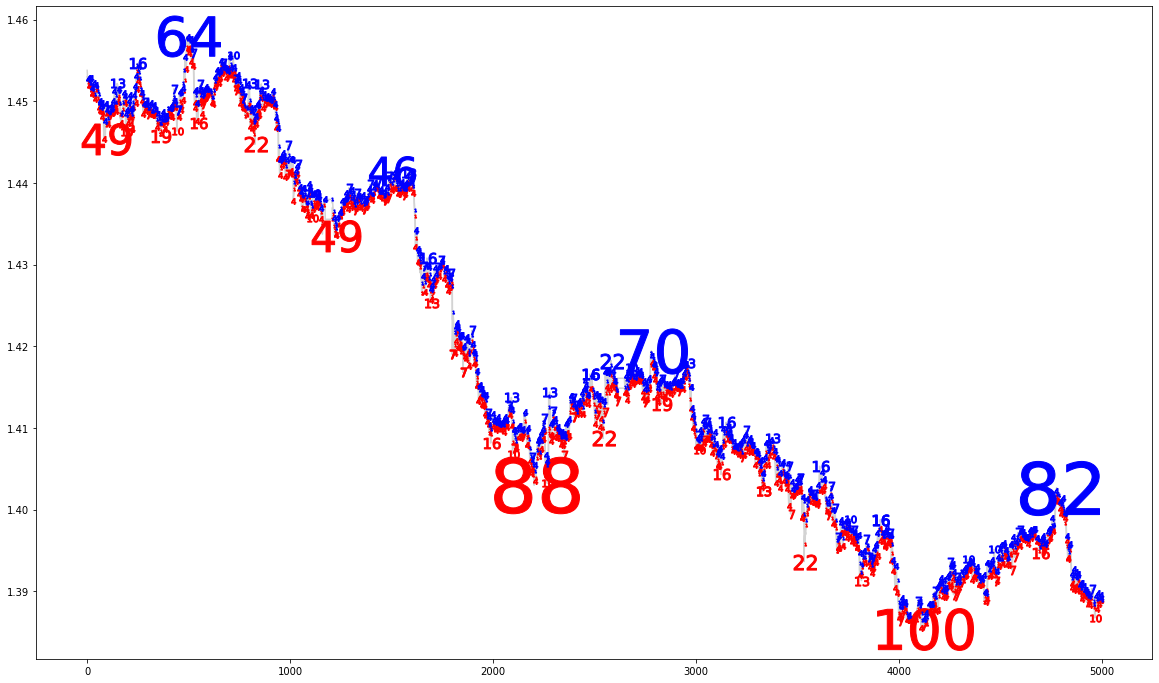

In [11]:
%%time
plt.figure(figsize = (20, 12)) 

plt.plot(np.arange(0, len(data.get("asklow")), 1), data.get("asklow"), c = "lightgrey")
plt.plot(np.arange(0, len(data.get("askhigh")), 1), data.get("askhigh"), c = "lightgrey")

for i in range(len(pointsLow)) : 
    #markerDown = "^"
    markerDown = "$"+str(pointsLow[i].get("score:wave"))+"$"
    colorDown = "red"
    plt.plot(pointsLow[i].get("index"), pointsLow[i].get("price"), 
             marker = markerDown, markersize = min(2+pointsLow[i].get("score:wave"), 12**2), color = colorDown)

for i in range(len(pointsHigh)) : 
    #markerUp = "v"
    markerUp = "$"+str(pointsHigh[i].get("score:wave"))+"$"
    colorUp = "blue"
    plt.plot(pointsHigh[i].get("index"), pointsHigh[i].get("price"), 
             marker = markerUp, markersize = min(2+pointsHigh[i].get("score:wave"), 12**2), color = colorUp)


## 2. Time scoring model 

In [12]:
def getTimeScoring(data, 
                   pointsLow, 
                   pointsHigh,
                   model = None, 
                   modelParamsLow = None,
                   modelParamsHigh = None) : 
    
    for i in range(len(pointsLow)) : 
        pointsLow[i].update({"score:time" : model(*modelParamsLow, pointsLow[i].get("index"))})
    for i in range(len(pointsHigh)) : 
        pointsHigh[i].update({"score:time" : model(*modelParamsHigh, pointsHigh[i].get("index"))})
    
    return pointsLow, pointsHigh

In [13]:
%%time


pointsLow, pointsHigh = math.getTimeScoring(data, pointsLow, pointsHigh, 
                                       model = exponential, 
                                       modelParamsLow = [size, tau, iniVal], 
                                       modelParamsHigh= [size, tau, iniVal])

CPU times: user 6.9 ms, sys: 80 µs, total: 6.98 ms
Wall time: 6.96 ms


CPU times: user 1.56 s, sys: 56 ms, total: 1.62 s
Wall time: 1.62 s


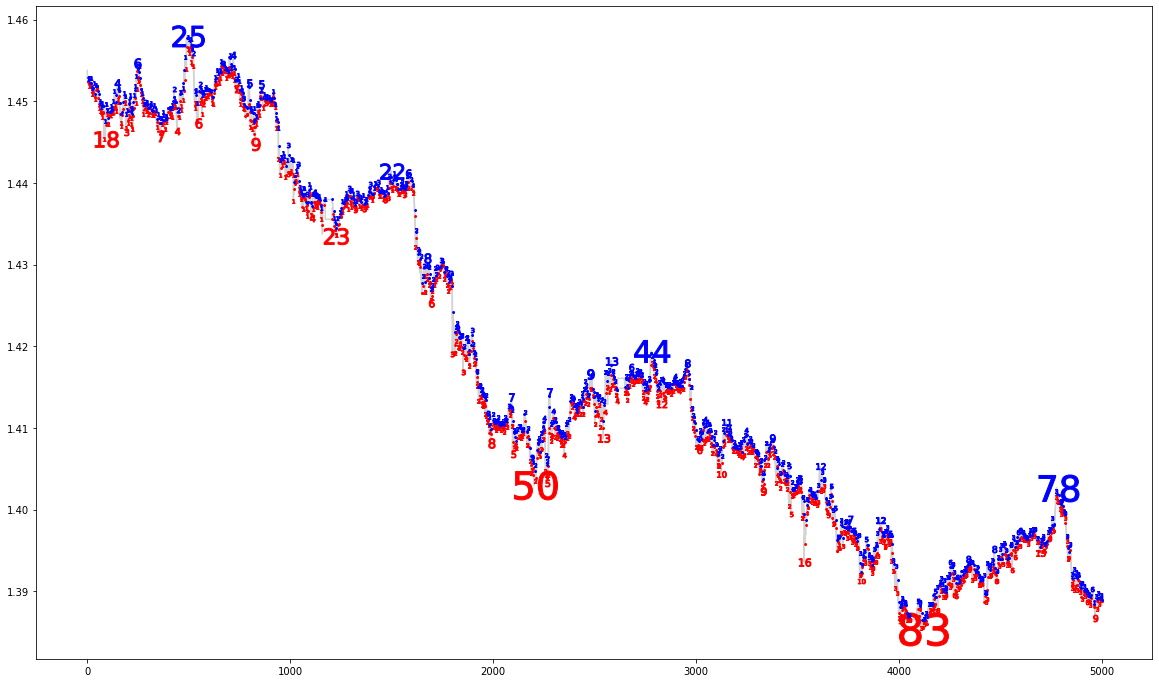

In [14]:
%%time
plt.figure(figsize = (20, 12)) 

plt.plot(np.arange(0, len(data.get("asklow")), 1), data.get("asklow"), c = "lightgrey")
plt.plot(np.arange(0, len(data.get("askhigh")), 1), data.get("askhigh"), c = "lightgrey")

for i in range(len(pointsLow)) : 
    #markerDown = "^"
    markerDown = "$"+str(int(pointsLow[i].get("score:wave")*pointsLow[i].get("score:time")))+"$"
    colorDown = "red"
    plt.plot(pointsLow[i].get("index"), pointsLow[i].get("price"), 
             marker = markerDown, markersize = min(2+int(pointsLow[i].get("score:wave")/2.), 12**2), color = colorDown)

for i in range(len(pointsHigh)) : 
    #markerUp = "v"
    markerUp = "$"+str(int(pointsHigh[i].get("score:wave")*pointsHigh[i].get("score:time")))+"$"
    colorUp = "blue"
    plt.plot(pointsHigh[i].get("index"), pointsHigh[i].get("price"), 
             marker = markerUp, markersize = min(2+int(pointsHigh[i].get("score:wave")/2.), 12**2), color = colorUp)

## 3. Line scoring model 

In [15]:
%%Time 
priceFactor = 10#1. 
timeFactor = 5#0.05 # Ratio XY (depending on the window dimensions)

for i in range(len(pointsLow)) : 
    # We calculate the volatility of the price at the point position
    locStd = np.std(data.get("askclose")[max(0, pointsLow[i].get("index") - stdRate) :pointsLow[i].get("index")]) 
    
    # We calculate the "size" of the point in the price/time directions 
    sigmaX = pointsLow[i].get("score:wave")*pointsLow[i].get("score:time")*timeFactor*1. 
    sigmaY = pointsLow[i].get("score:wave")*pointsLow[i].get("score:time")*priceFactor*locStd/waveScoreRange[1]
    
    pointsLow[i].update({"volatility" : locStd, 
                         "sigma X"    : sigmaX, 
                         "sigma Y"    : sigmaY})
    
for i in range(len(pointsHigh)) : 
    # We calculate the volatility of the price at the point position
    locStd = np.std(data.get("askclose")[max(0, pointsHigh[i].get("index") - stdRate) :pointsHigh[i].get("index")]) 
    
    # We calculate the "size" of the point in the price/time directions 
    sigmaX = pointsHigh[i].get("score:wave")*pointsHigh[i].get("score:time")*timeFactor*1. 
    sigmaY = pointsHigh[i].get("score:wave")*pointsHigh[i].get("score:time")*priceFactor*locStd/waveScoreRange[1]
    
    pointsHigh[i].update({"volatility" : locStd, 
                         "sigma X"    : sigmaX, 
                         "sigma Y"    : sigmaY})
    
    

    

UsageError: Cell magic `%%Time` not found.


In [16]:
%%time
from matplotlib.patches import Ellipse

fig = plt.figure(figsize = (20, 12)) 
ax = fig.add_subplot(111)

ax.plot(np.arange(0, len(data.get("asklow")), 1), data.get("asklow"), c = "lightgrey")
ax.plot(np.arange(0, len(data.get("askhigh")), 1), data.get("askhigh"), c = "lightgrey")

for i in range(len(pointsLow)) : 
    xcenter = pointsLow[i].get("index")
    ycenter = pointsLow[i].get("price")
    width   = pointsLow[i].get("sigma X") 
    height  = pointsLow[i].get("sigma Y")
    angle   = 0 
    e = Ellipse((xcenter, ycenter), width, height,
                     angle=angle, linewidth=1, fill=True, zorder=2, color = "red")
    ax.add_patch(e)

for i in range(len(pointsHigh)) : 
    xcenter = pointsHigh[i].get("index")
    ycenter = pointsHigh[i].get("price")
    width   = pointsHigh[i].get("sigma X") 
    height  = pointsHigh[i].get("sigma Y")
    angle   = 0 
    e = Ellipse((xcenter, ycenter), width, height,
                     angle=angle, linewidth=1, fill=True, zorder=2, color = "blue")
    ax.add_patch(e)


plt.show()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [17]:
def gaussian2DAmp(x, y, x0, y0, sig_x, sig_y, A) : 
    return A*np.exp(-((x-x0)**2/(2.*sig_x**2) + (y-y0)**2/(2.*sig_y**2)))

def heaviside(x, y, x0, y0, sig_x, sig_y, A) : 
    return A*np.heaviside(-abs(x - x0) + sig_x, 1) + A*np.heaviside(-abs(y - y0) + sig_y, 1)


In [18]:
%%time


# We define the coordinates frame 
xProbe = [np.inf, 0] 
yProbe = [np.inf, 0] 

for i in range(len(pointsLow)) : 
    if pointsLow[i].get("price") < yProbe[0] : 
        yProbe[0] = pointsLow[i].get("price")
    if pointsLow[i].get("index") < xProbe[0] : 
        xProbe[0] = pointsLow[i].get("index")
    if pointsLow[i].get("index") > xProbe[1] : 
        xProbe[1] = pointsLow[i].get("index") 

for i in range(len(pointsHigh)) : 
    if pointsHigh[i].get("price") > yProbe[1] : 
        yProbe[1] = pointsHigh[i].get("price")
    if pointsHigh[i].get("index") < xProbe[0] : 
        xProbe[0] = pointsHigh[i].get("index")
    if pointsHigh[i].get("index") > xProbe[1] : 
        xProbe[1] = pointsHigh[i].get("index") 

#print (xProbe, yProbe)
#sortedPtsLow = sorted(ptsLow, key=lambda ptsLow: ptsLow[2], reverse = True)

pointsHigh = sorted(pointsHigh, key=lambda pointsHigh: pointsHigh.get("score:wave"), reverse = True)
pointsLow = sorted(pointsLow, key=lambda pointsLow: pointsLow.get("score:wave"), reverse = True)


dx = 0.1 
dy = 0.01

xProbe[0] = int(xProbe[0]*(1 - dx))
xProbe[1] = int(xProbe[1]*(1 + dx))
yProbe[0] = yProbe[0]*(1 - dy)
yProbe[1] = yProbe[1]*(1 + dy)

Nx = 1000 
Ny = 500 
X = np.linspace(xProbe[0], xProbe[1], Nx) 
Y = np.linspace(yProbe[0], yProbe[1], Ny)

Xv, Yv = np.meshgrid(X, Y) 

Z = Xv*0. 
for i in range(len(pointsLow)) : 
    Z += gaussian2DAmp(Xv, Yv, 
                       pointsLow[i].get("index"), 
                       pointsLow[i].get("price"), 
                       pointsLow[i].get("sigma X"), 
                       pointsLow[i].get("sigma Y"), 
                       1)*pointsLow[i].get("score:wave")
for i in range(len(pointsHigh)) : 
    Z += gaussian2DAmp(Xv, Yv, 
                       pointsHigh[i].get("index"), 
                       pointsHigh[i].get("price"), 
                       pointsHigh[i].get("sigma X"), 
                       pointsHigh[i].get("sigma Y"), 
                       1)*pointsHigh[i].get("score:wave")

from scipy import interpolate 


f = interpolate.interp2d(X, Y, Z, kind='cubic')

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

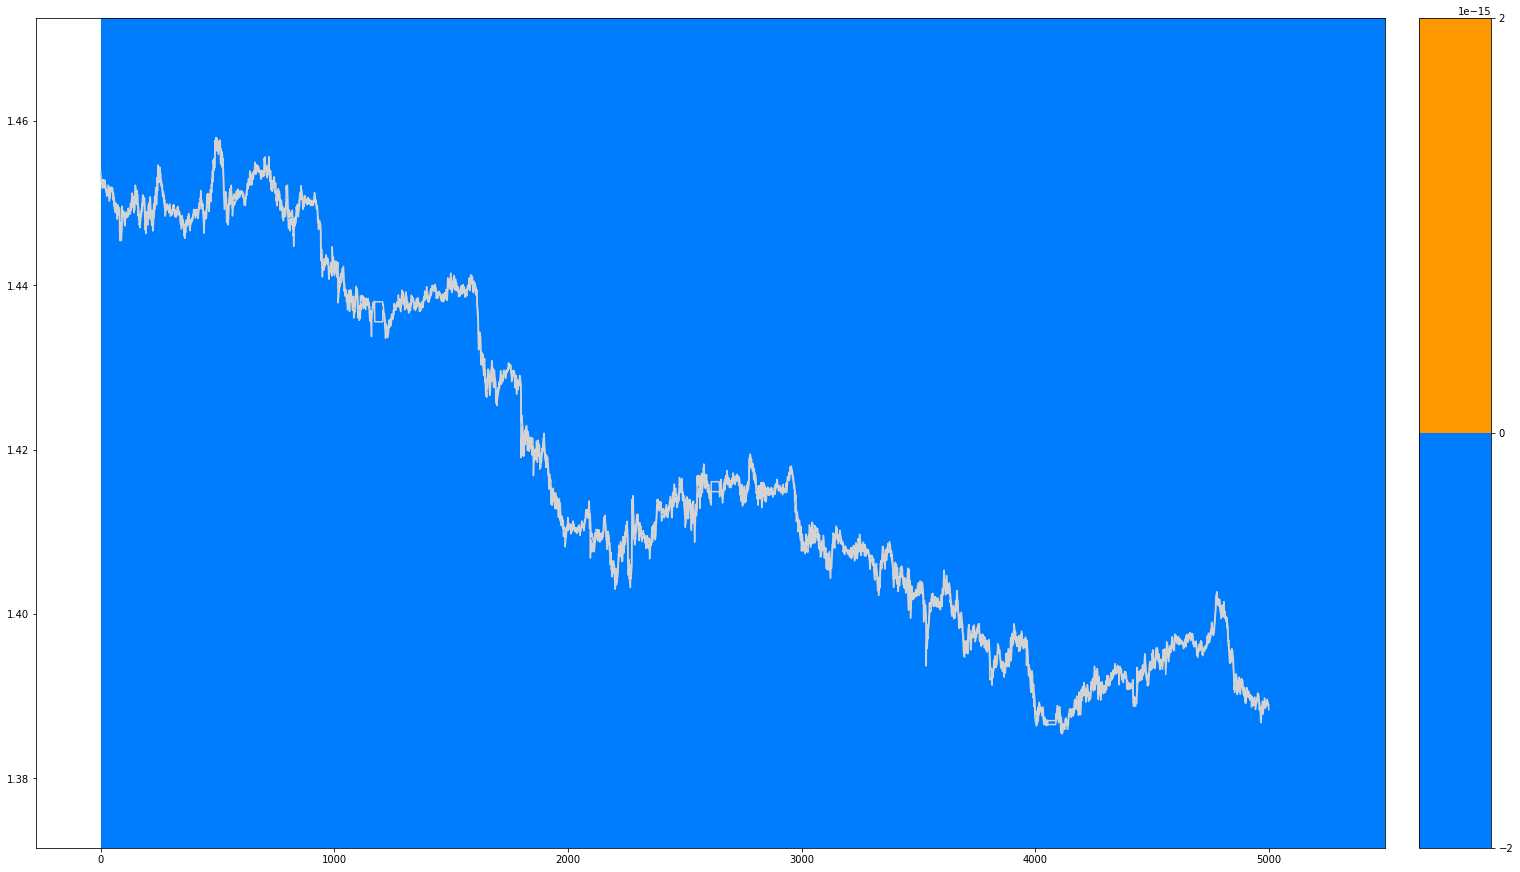

CPU times: user 3.11 s, sys: 206 ms, total: 3.31 s
Wall time: 2.74 s


In [19]:
%%time
fig, ax = plt.subplots(constrained_layout=True, figsize=(21,12))

ax.plot(np.arange(0, len(data.get("asklow")), 1), data.get("asklow"), c = "lightgrey")
ax.plot(np.arange(0, len(data.get("askhigh")), 1), data.get("askhigh"), c = "lightgrey")

cs = ax.contourf(X,Y,Z, 100, cmap=plt.cm.get_cmap('jet'))
cbar = fig.colorbar(cs )
plt.savefig("test.png", dpi=300)
plt.show()

In [20]:
%%time
# We generate the theta array 
nTheta = 100 
eps = 0.001
ratio_xy = 1
thetaArray  = np.linspace(eps, np.pi - eps, nTheta)
treesholdScore = 10
step_x = 10


tanThetaArray = np.tan(thetaArray)
alpha = (xProbe[1] - xProbe[0])/(yProbe[1] - yProbe[0])*ratio_xy



i = 0 
while pointsLow[i].get("score:wave") >= treesholdScore : 
    locPrice = pointsLow[i].get("price") 
    locIndex = pointsLow[i].get("index")
    thetaLine = list() 
    for k in range(len(thetaArray)) : 
        locX = list() 
        locY = list()
        for j in range(xProbe[0], xProbe[1], step_x) : 
            yVal = locPrice + (locIndex - j)/tanThetaArray[k]/alpha
            if yVal >= yProbe[0] and yVal <= yProbe[1] : 
                locX.append(j)
                locY.append(yVal)
        thetaLine.append([locX, locY])

    pointsLow[i].update({"theta line" : thetaLine})
    i += 1

i = 0 
while pointsHigh[i].get("score:wave") >= treesholdScore : 
    locPrice = pointsHigh[i].get("price") 
    locIndex = pointsHigh[i].get("index")
    thetaLine = list() 
    for k in range(len(thetaArray)) : 
        locX = list() 
        locY = list()
        for j in range(xProbe[0], xProbe[1], step_x) : 
            yVal = locPrice + (locIndex - j)/tanThetaArray[k]/alpha
            if yVal >= yProbe[0] and yVal <= yProbe[1] : 
                locX.append(j)
                locY.append(yVal)
        thetaLine.append([locX, locY])

    pointsHigh[i].update({"theta line" : thetaLine})
    i += 1 


        


CPU times: user 2.44 s, sys: 9.67 ms, total: 2.45 s
Wall time: 2.45 s


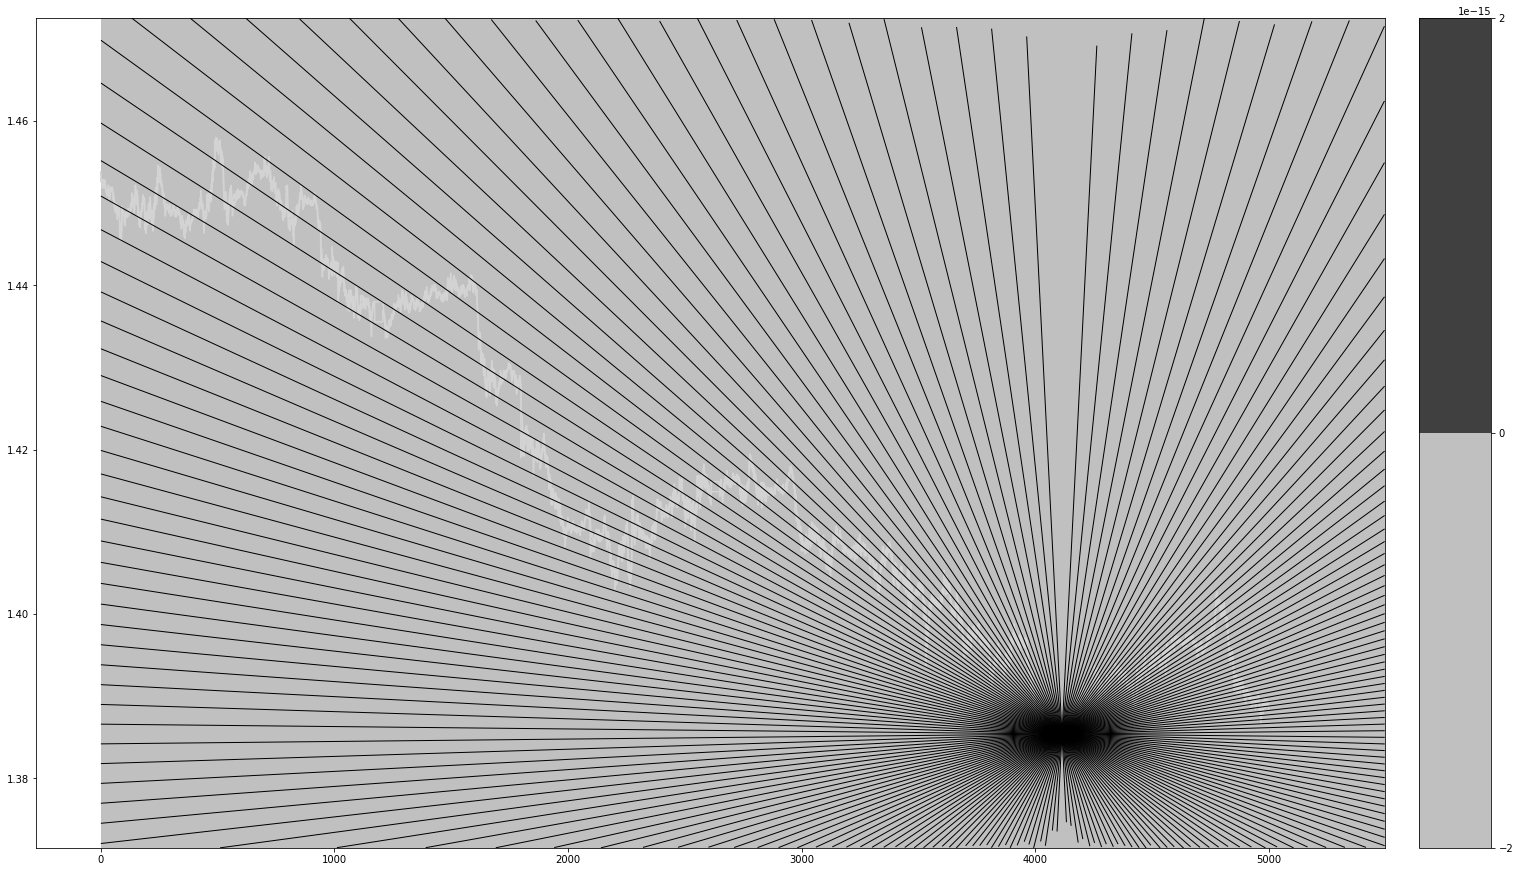

CPU times: user 4.8 s, sys: 219 ms, total: 5.02 s
Wall time: 4 s


In [21]:
%%time
fig, ax = plt.subplots(constrained_layout=True, figsize=(21,12))

ax.plot(np.arange(0, len(data.get("asklow")), 1), data.get("asklow"), c = "lightgrey")
ax.plot(np.arange(0, len(data.get("askhigh")), 1), data.get("askhigh"), c = "lightgrey")

cs = ax.contourf(X,Y,Z, 100, cmap=plt.cm.get_cmap('binary'))

k = 0 
for i in range(len(pointsLow[k].get("theta line"))) : 
    
    ax.plot(pointsLow[k].get("theta line")[i][0], 
            pointsLow[k].get("theta line")[i][1], lw = 1, color = "black")
    
cbar = fig.colorbar(cs )
plt.savefig("test.png", dpi=300)
plt.show()

In [22]:
%%time
for i in range(len(pointsLow)) : 
    pointsLow[i].update({"score:line" : 1})
for i in range(len(pointsHigh)) : 
    pointsHigh[i].update({"score:line" : 1})

i = 0 
while pointsLow[i].get("score:wave") >= treesholdScore : 
#for i in range(len(pointsLow)) : 
    pointsLow[i].update({"theta value" : None})
    pointsLow[i].update({"theta integral" : None})
    if pointsLow[i].get("theta line") is not None : 
        print ("Score:wave : ",pointsLow[i].get("score:wave")," / Treeshold : ",treesholdScore)
        thetaValue = list()
        thetaInt   = list() 
        for j in range(len(pointsLow[i].get("theta line"))) : 
            locThetaVal = list()
            for k in range(len(pointsLow[i].get("theta line")[j][0])) : 
                locSum = 0 
                x0 = pointsLow[i].get("theta line")[j][0][k] 
                y0 = pointsLow[i].get("theta line")[j][1][k]
                
                locSum += f(x0, y0) - gaussian2DAmp(x0, y0, 
                                                    pointsLow[i].get("index"), 
                                                    pointsLow[i].get("price"), 
                                                    pointsLow[i].get("sigma X"), 
                                                    pointsLow[i].get("sigma Y"), 
                                                    1)*pointsLow[i].get("score:wave")
                
                locThetaVal.append(locSum)
            thetaValue.append(locThetaVal)
            thetaInt.append(sum(locThetaVal))
            #print ("locSum = ",locSum)
        pointsLow[i].update({"theta value" : thetaValue})
        pointsLow[i].update({"theta integral" : thetaInt})
        pointsLow[i].update({"score:line" : sum(thetaInt)[0]})
    i += 1 
        
i = 0 
while pointsHigh[i].get("score:wave") >= treesholdScore :
#for i in range(len(pointsHigh)) : 
    pointsHigh[i].update({"theta value" : None})
    pointsHigh[i].update({"theta integral" : None})
    if pointsHigh[i].get("theta line") is not None : 
        print ("Score:wave : ",pointsHigh[i].get("score:wave")," / Treeshold : ",treesholdScore)
        thetaValue = list()
        thetaInt   = list() 
        for j in range(len(pointsHigh[i].get("theta line"))) : 
            locThetaVal = list()
            for k in range(len(pointsHigh[i].get("theta line")[j][0])) : 
                locSum = 0 
                x0 = pointsHigh[i].get("theta line")[j][0][k] 
                y0 = pointsHigh[i].get("theta line")[j][1][k]
                
                locSum += f(x0, y0)   - gaussian2DAmp(x0, y0, 
                                                      pointsHigh[i].get("index"), 
                                                      pointsHigh[i].get("price"), 
                                                      pointsHigh[i].get("sigma X"), 
                                                      pointsHigh[i].get("sigma Y"), 
                                                      1)*pointsHigh[i].get("score:wave")
                
                locThetaVal.append(locSum)
            thetaValue.append(locThetaVal)
            thetaInt.append(sum(locThetaVal))
            #print ("locSum = ",locSum)
        pointsHigh[i].update({"theta value" : thetaValue})
        pointsHigh[i].update({"theta integral" : thetaInt})
        pointsHigh[i].update({"score:line" : sum(thetaInt)[0]})
    i += 1 

    


Score:wave :  100  / Treeshold :  10


NameError: name 'f' is not defined

In [252]:
%%time
maxScoreLine = 0 
for i in range(len(pointsLow)) : 
    if pointsLow[i].get("score:line") > maxScoreLine : 
        maxScoreLine = pointsLow[i].get("score:line")
for i in range(len(pointsHigh)) : 
    if pointsHigh[i].get("score:line") > maxScoreLine : 
        maxScoreLine = pointsHigh[i].get("score:line")
        
print("maxScore line : ",maxScoreLine)
print(pointsLow[10].get("score:line"))

maxScore line :  3871.716601834959
1127.8524564546433


In [253]:
%%time
# We normalize the score of the different points over a score range 

def lineScoreNormalize(pointsLow, 
                       pointsHigh, 
                       lineScoreRange = [1, 100]) : 

    maxScore = 0 
    minScore = np.inf 
    for i in range(len(pointsLow)) : 
        if pointsLow[i].get("score:line") > maxScore : 
            maxScore = pointsLow[i].get("score:line")
        if pointsLow[i].get("score:line") < minScore : 
            minScore = pointsLow[i].get("score:line")
    for i in range(len(pointsHigh)) : 
        if pointsHigh[i].get("score:line") > maxScore : 
            maxScore = pointsHigh[i].get("score:line")
        if pointsHigh[i].get("score:line") < minScore : 
            minScore = pointsHigh[i].get("score:line")
    
    factor = (lineScoreRange[1] - lineScoreRange[0])/(maxScore - minScore)

    for i in range(len(pointsLow)) : 
        pointsLow[i].update({"score:line" : int(lineScoreRange[0] + (pointsLow[i].get("score:line") - minScore)*factor)})
    for i in range(len(pointsHigh)) : 
        pointsHigh[i].update({"score:line" : int(lineScoreRange[0] + (pointsHigh[i].get("score:line") - minScore)*factor)})
    
    return pointsLow, pointsHigh


lineScoreRange = [1, 100]
pointsLow, pointsHigh = lineScoreNormalize(pointsLow, 
                                           pointsHigh, 
                                           lineScoreRange = lineScoreRange)

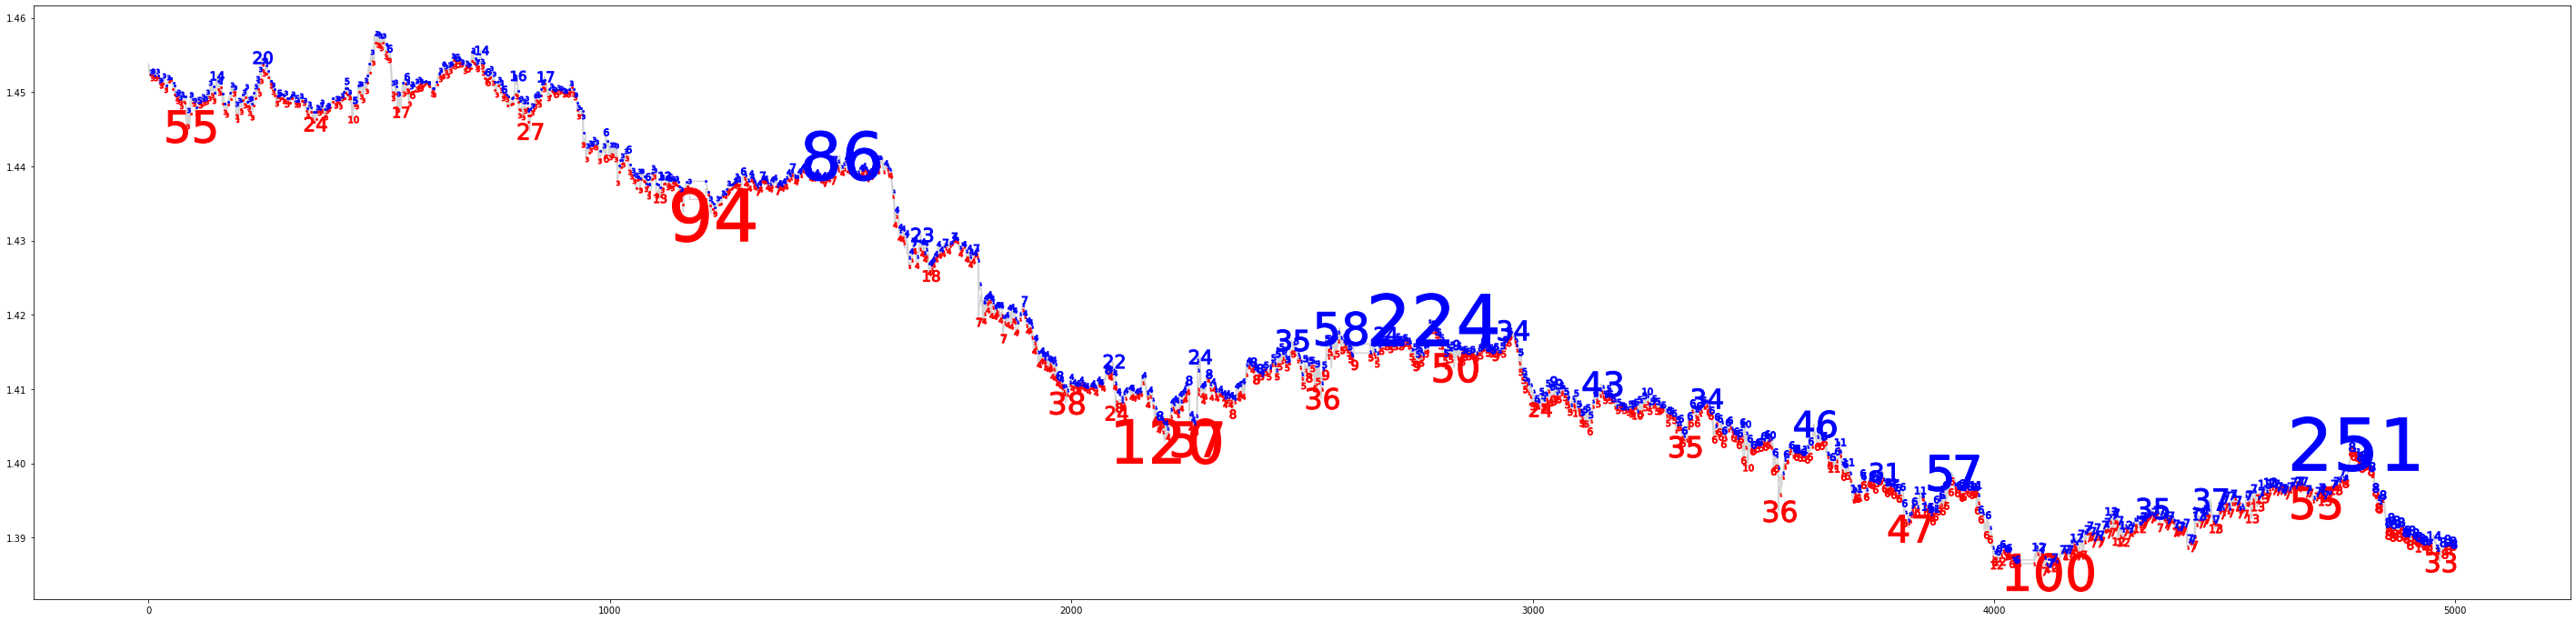

In [256]:
%%time
plt.figure(figsize = (50, 12)) 

plt.plot(np.arange(0, len(data.get("asklow")), 1), data.get("asklow"), c = "lightgrey")
plt.plot(np.arange(0, len(data.get("askhigh")), 1), data.get("askhigh"), c = "lightgrey")

for i in range(len(pointsLow)) : 
    #markerDown = "^"
    markerDown = "$"+str(int(0.1*(pointsLow[i].get("score:line")*pointsLow[i].get("score:wave"))*pointsLow[i].get("score:time")))+"$"
    colorDown = "red"
    plt.plot(pointsLow[i].get("index"), pointsLow[i].get("price"), 
             marker = markerDown, markersize = min(2+int(0.1*(pointsLow[i].get("score:line")*pointsLow[i].get("score:wave"))*pointsLow[i].get("score:time")), 12**2), color = colorDown)

for i in range(len(pointsHigh)) : 
    #markerUp = "v"
    markerUp = "$"+str(int(0.1*(pointsHigh[i].get("score:line")*pointsHigh[i].get("score:wave"))*pointsHigh[i].get("score:time")))+"$"
    colorUp = "blue"
    plt.plot(pointsHigh[i].get("index"), pointsHigh[i].get("price"), 
             marker = markerUp, markersize = min(2+int(0.1*(pointsHigh[i].get("score:line")*pointsHigh[i].get("score:wave"))*pointsHigh[i].get("score:time")), 12**2), color = colorUp)
    
    
plt.savefig("test.svg", dpi=900)


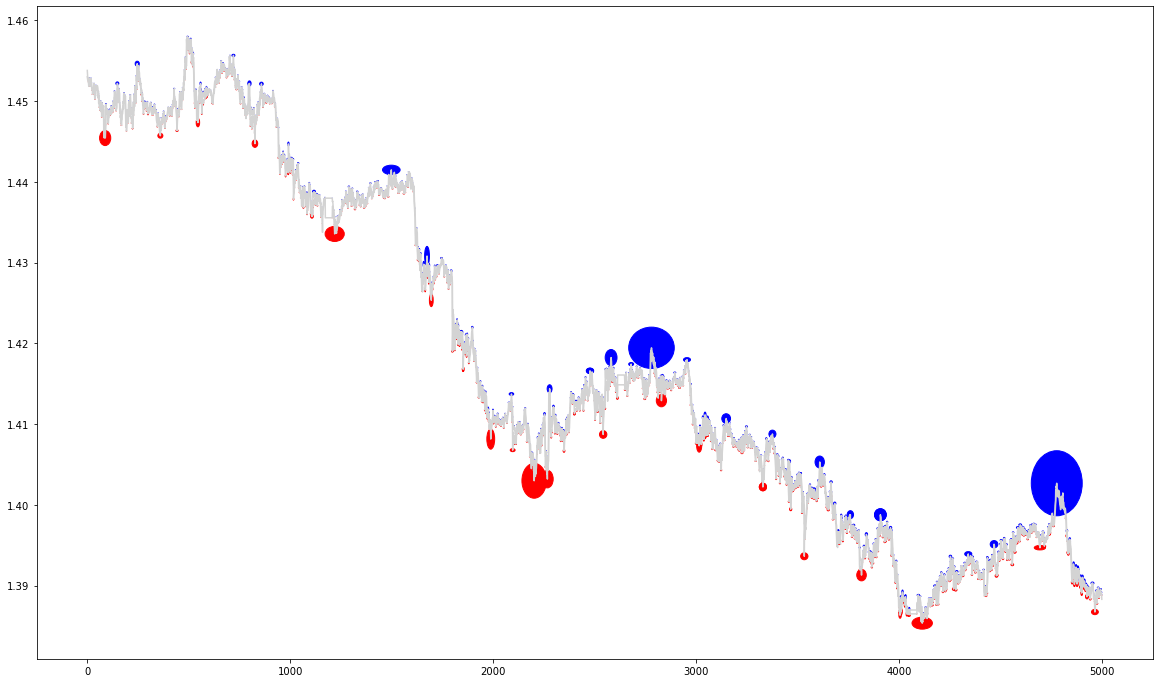

In [260]:
%%time
from matplotlib.patches import Ellipse

fig = plt.figure(figsize = (20, 12)) 
ax = fig.add_subplot(111)

ax.plot(np.arange(0, len(data.get("asklow")), 1), data.get("asklow"), c = "lightgrey")
ax.plot(np.arange(0, len(data.get("askhigh")), 1), data.get("askhigh"), c = "lightgrey")

for i in range(len(pointsLow)) : 
    xcenter = pointsLow[i].get("index")
    ycenter = pointsLow[i].get("price")
    width   = pointsLow[i].get("sigma X")*pointsLow[i].get("score:line")/50. 
    height  = pointsLow[i].get("sigma Y")*pointsLow[i].get("score:line")/50. 
    angle   = 0 
    e = Ellipse((xcenter, ycenter), width, height,
                     angle=angle, linewidth=1, fill=True, zorder=2, color = "red")
    ax.add_patch(e)

for i in range(len(pointsHigh)) : 
    xcenter = pointsHigh[i].get("index")
    ycenter = pointsHigh[i].get("price")
    width   = pointsHigh[i].get("sigma X")*pointsHigh[i].get("score:line")/50.  
    height  = pointsHigh[i].get("sigma Y")*pointsHigh[i].get("score:line")/50. 
    angle   = 0 
    e = Ellipse((xcenter, ycenter), width, height,
                     angle=angle, linewidth=1, fill=True, zorder=2, color = "blue")
    ax.add_patch(e)


plt.show()

In [57]:
%%time
maxSorted = 1000

ptsLow = list()
for i in range(len(pointLB@sLow)) : 
    if pointsLow[i].get("theta line") is not None : 
        locIndex = pointsLow[i].get("theta integral").index(max(pointsLow[i].get("theta integral")))
        locVal   = max(pointsLow[i].get("theta integral"))
        ptsLow.append((i, locIndex, locVal))
        
sortedPtsLow = sorted(ptsLow, key=lambda ptsLow: ptsLow[2], reverse = True)



ptsHigh = list()
for i in range(len(pointsHigh)) : 
    if pointsHigh[i].get("theta line") is not None : 
        locIndex = pointsHigh[i].get("theta integral").index(max(pointsHigh[i].get("theta integral")))
        locVal   = max(pointsHigh[i].get("theta integral"))
        ptsHigh.append((i, locIndex, locVal))
        
sortedPtsHigh = sorted(ptsHigh, key=lambda ptsHigh: ptsHigh[2], reverse = True)
        
 

[61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]


/home/loann/Programmes/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


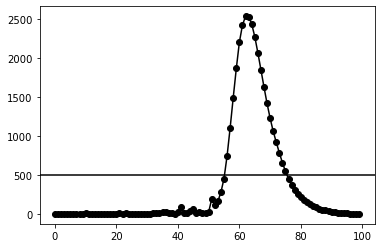

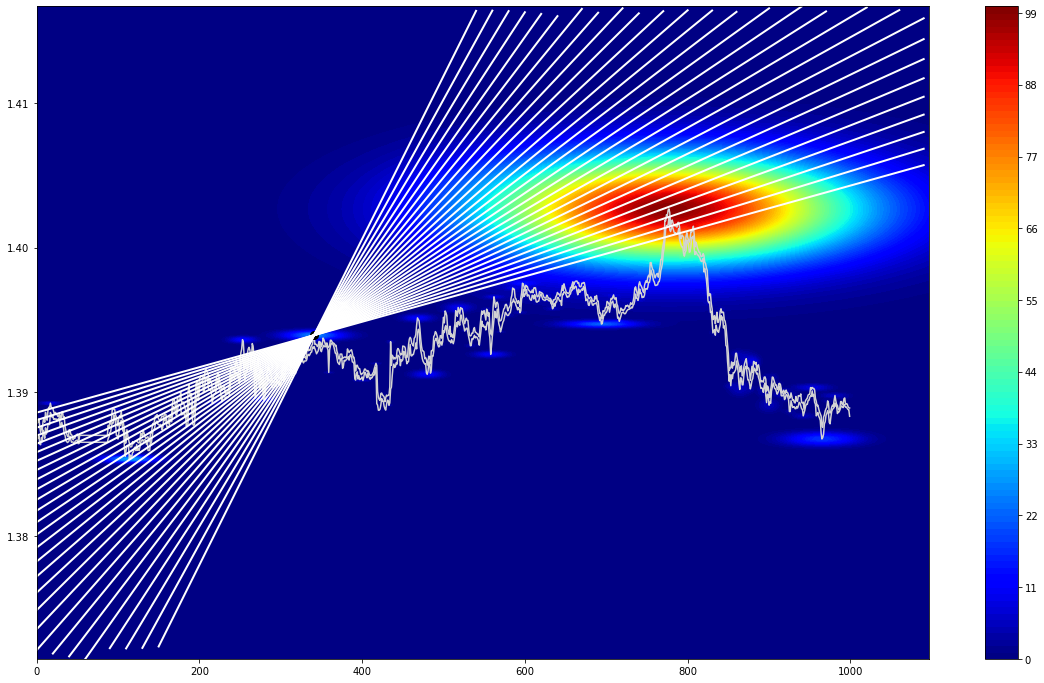

In [58]:
%%time
k = 1
treesholdIndex = 500 
plt.figure() 
    
plt.plot(pointsHigh[k].get("theta integral"), c = "black", marker = 'o')
plt.axhline(treesholdIndex, c="black")

indexMax = list()

for i in range(len(pointsLow[k].get("theta integral"))) : 
    if pointsLow[k].get("theta integral")[i] >= treesholdIndex : 
        indexMax.append(i)

#indexMax = pointsLow[k].get("theta integral").index(max(pointsLow[k].get("theta integral")))
print (indexMax)
plt.show()

fig = plt.figure(figsize = (20, 12)) 
ax = fig.add_subplot(111)

ax.plot(np.arange(0, len(data.get("asklow")), 1), data.get("asklow"), c = "lightgrey")
ax.plot(np.arange(0, len(data.get("askhigh")), 1), data.get("askhigh"), c = "lightgrey")

cs = ax.contourf(X,Y,Z, 100, cmap=plt.cm.get_cmap('jet'))


    
ax.plot(pointsHigh[k].get("index"), pointsHigh[k].get("price"), marker = "o", markersize = 8, color = "black")

for i in range(len(indexMax)) : 
    ax.plot(pointsHigh[k].get("theta line")[indexMax[i]][0], 
            pointsHigh[k].get("theta line")[indexMax[i]][1], lw = 2, color = "white")

cbar = fig.colorbar(cs )
plt.show()